In [8]:
import datetime
import math

import ephem
from dateutil import parser

In [9]:
def next_passes(station, satellite, start_date, end_date, step=1, factor=1):
    steps = {10: math.radians(2),
             1: math.radians(0.1),
             0.1: math.radians(0.01),
             0.01: math.radians(0.001),
             0.001: math.radians(0)}
    start_date = ephem.date(start_date)
    end_date = ephem.date(end_date)
    passes = []
    station.date = start_date
    station.pressure = 0
    pass_on_going = False
    pass_data = {}
    while station.date <= end_date:
        satellite.compute(station)
        if satellite.alt >= math.radians(-0.227):
            if not pass_on_going:
                pass_data = {'start': station.date.datetime(), 'steps': []}
                pass_on_going = True
        else:
            if pass_on_going:
                pass_data['end'] = station.date.datetime()
                passes.append(pass_data)
                pass_on_going = False
        station.date += ephem.second * max([i for i in steps.keys() if abs(satellite.alt) > steps[i]]) / factor
    if pass_on_going:
        pass_data['end'] = end_date.datetime()
        passes.append(pass_data)
    for i in range(len(passes)):
        current_date = passes[i]['start']
        end_date = passes[i]['end']
        station.date = ephem.date(current_date)
        while current_date < end_date:
            satellite.compute(station)
            passes[i]['steps'].append({'time': current_date,
                                       'azimuth': math.degrees(satellite.az),
                                       'elevation': math.degrees(satellite.alt),
                                       'range': satellite.range,
                                       'velocity': satellite.range_velocity})
            current_date = current_date.replace(microsecond=0) + datetime.timedelta(seconds=step)
            station.date = ephem.date(current_date)
        station.date = ephem.date(end_date)
        satellite.compute(station)
        passes[i]['steps'].append({'time': end_date,
                                   'azimuth': math.degrees(satellite.az),
                                   'elevation': math.degrees(satellite.alt),
                                   'range': satellite.range,
                                   'velocity': satellite.range_velocity})
    return [sat_pass for sat_pass in passes if max([i['elevation'] for i in sat_pass['steps']]) > 0]


def main(latitude, longitude, altitude, tle, duration=1, start=None, interval=60):
    if not start:
        start = datetime.datetime.utcnow()
    station = ephem.Observer()
    station.lat = math.radians(latitude)
    station.long = math.radians(longitude)
    station.elevation = altitude
    with open(tle, 'r') as f:
        satellite = ephem.readtle(*f.readlines())
    if isinstance(start, str):
        start = parser.parse(start)
    end = start + datetime.timedelta(days=duration)
    passes = next_passes(station, satellite, start, end, step=interval)
    print('time; azimuth; elevation; range; radial velocity')
    for i in passes:
        for entry in i['steps']:
            print('{}; {}; {}; {}; {}'.format(entry['time'].isoformat(),
                                              entry['azimuth'],
                                              entry['elevation'],
                                              entry['range'],
                                              entry['velocity']))

In [15]:
station_1 = ephem.Observer()
station_1.lat = math.radians(51.41)
station_1.long = math.radians(-0.195)
station_1.elevation = 50

station_2 = ephem.Observer()
station_2.lat = math.radians(51.414)
station_2.long = math.radians(-0.195)
station_2.elevation = 50

with open('viasat.tle', 'r') as f:
    satellite = ephem.readtle(*f.readlines())

start = datetime.datetime.utcnow()
end = start + datetime.timedelta(days=1)
passes_1 = next_passes(station_1, satellite, start, end, step=60)
passes_2 = next_passes(station_2, satellite, start, end, step=60)

In [16]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

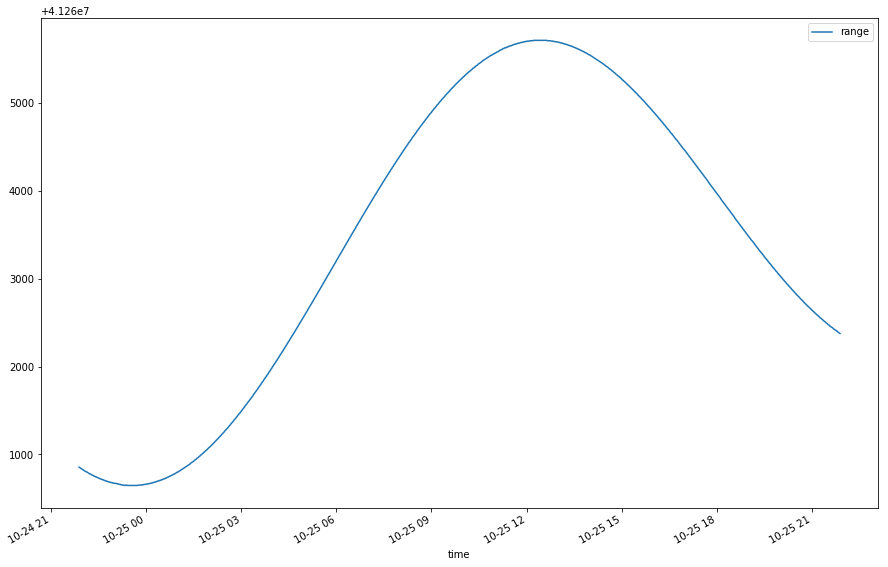

In [17]:
pd.DataFrame(passes_1[0]['steps']).set_index('time').plot(y='range', use_index=True)

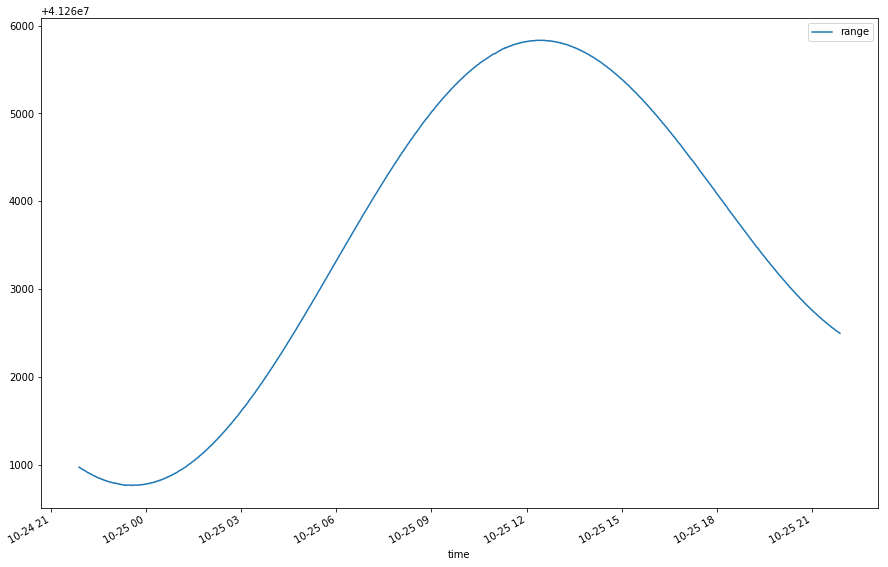

In [18]:
pd.DataFrame(passes_2[0]['steps']).set_index('time').plot(y='range', use_index=True)

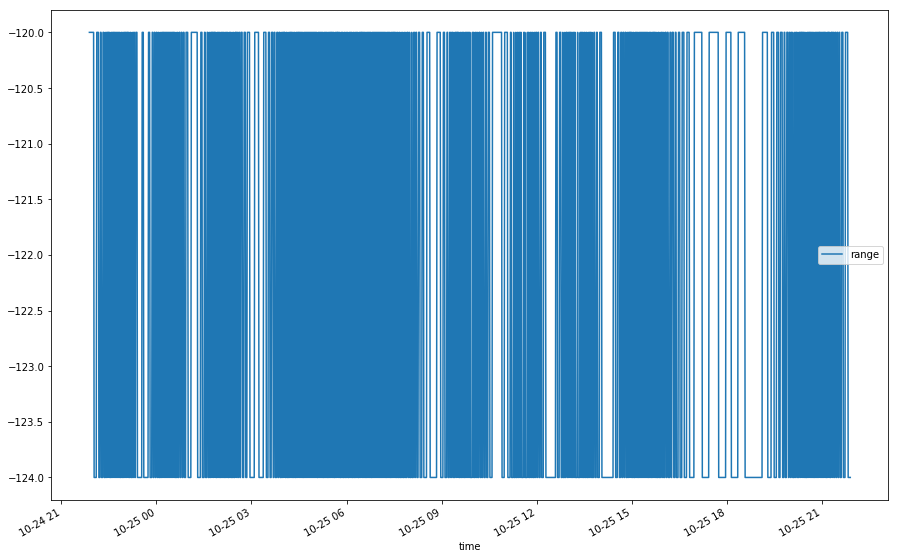

In [19]:
(pd.DataFrame(passes_1[0]['steps']).set_index('time') - pd.DataFrame(passes_2[0]['steps']).set_index('time')).plot(y='range', use_index=True)